In [1]:
#Implementation of the PSWFs by NN. 

In [2]:
# Standard libraries
import time
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

# SymPy for symbolic mathematics
import sympy
from sympy import symbols, exp, re, im, I, E

# Scikit-learn for machine learning utilities
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import cohen_kappa_score, f1_score

# SciPy for mathematical optimizations and special functions
from scipy.optimize import minimize
from scipy.special import pro_ang1
from scipy.ndimage import rotate

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Cropping1D, Concatenate, MaxPooling1D, Dropout, 
    Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, 
    GlobalAveragePooling1D, Lambda, Input, Add, UpSampling1D, Multiply
)
from tensorflow.keras.losses import (
    mean_squared_error, Hinge, binary_crossentropy, categorical_crossentropy
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, 
    LearningRateScheduler, Callback
)



2025-01-30 14:19:47.002053: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 14:19:47.003550: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:19:47.034377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:19:47.034881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 14:19:48.851140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Definimos el valor de K

def Archit(K):

       """
    Generates an array representing a neural network architecture.

    Parameters:
    K : list or tuple
        K[0] - Number of layers (L)
        K[1] - Scaling factor for neurons per layer

    Returns:
    Lay_x_Neu : ndarray
        An array where each row represents (layer index, neurons in the layer).
    """
    # Create an array with values from 1 to K[0] (number of layers)
    Array = np.arange(1, K[0] + 1)

    # Create a 2D array with the structure (layer index, neurons in the layer)
    Lay_x_Neu = np.column_stack((Array, K[1] * Array))

    return Lay_x_Neu

In [4]:
# Define the number of training samples using logarithmic spacing
Nsamples = np.logspace(2, np.log10(10000, num=10)

# Define the number of test samples as 20% of the training samples
Ntest = 0.2 * Nsamples


In [5]:
# This function approximates the given mathematical expression
def funct(t):
    """
    Computes the function g(x, y) = cos(0.2 * x) * exp(-π * (x^2 + y^2)) * cos(0.2 * y).
    
    Parameters:
    t : array-like, shape (n_samples, 2)
        An array with two columns: the first column contains x-values, and the second column contains y-values.
    
    Returns:
    g : array-like, shape (n_samples,)
        The computed function values at each (x, y) pair.
    """
    
    # Extract x and y values from the input array 't'
    x = t[:, 0]  # Access the first column (x-values)
    y = t[:, 1]  # Access the second column (y-values)
    
    # Compute the function g(x, y)
    g = np.cos(0.2 * x) * np.exp(-np.pi * (x**2 + y**2)) * np.cos(0.2 * y)
    
    return g


In [6]:
# Define the function to generate samples
def samps(t):
    """
    Generates 't' random samples uniformly distributed between -1 and 1,
    for both X and Y, and stacks them as input features.

    Parameters:
    t : int
        The number of samples to generate.

    Returns:
    inputs : ndarray, shape (t, 2)
        A 2D array with 't' samples of X and Y as input features.
    """
    
    # Generate random samples for X and Y (uniformly distributed between -1 and 1)
    Values = np.random.uniform(-1, 1, t)
    Values2 = np.random.uniform(-1, 1, t)
      
    # Flatten the sorted arrays (just in case, although they are already 1D)
    X_flat = Values.ravel()
    Y_flat = Values2.ravel()

    # Stack X and Y into a 2D array (each row represents an (X, Y) pair)
    inputs = np.vstack([X_flat, Y_flat]).T
    
    return inputs


In [7]:
def create_simple_NN(X_samp, labels, L, activation='relu'):
    """
    Creates a simple feedforward neural network model with L hidden layers.

    Parameters:
    X_samp : ndarray, shape (n_samples, n_features)
        The input data (training samples).
    labels : ndarray, shape (n_samples,)
        The output labels corresponding to the input data.
    L : list or tuple
        The first element is the number of hidden layers, and the second element is the number of neurons in each hidden layer.
    activation : str, optional, default='relu'
        The activation function for the hidden layers. Default is ReLU.

    Returns:
    model : tf.keras.Model
        The compiled Keras model.
    """
    
    # Input layer
    model_input = Input(shape=(X_samp.shape[1],))

    # Hidden layers
    x = model_input
    for i in range(L[0]):  # L[0] is the number of layers
        x = Dense(L[1], activation=activation, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1))(x)
    
    # Output layer (single neuron for regression)
    out = Dense(1)(x)

    # Create the model
    model = Model(inputs=model_input, outputs=out)

    return model



In [8]:
# Parameters for training
initial_learning_rate = 0.001  # Initial learning rate
decay_steps = 1000             # Number of steps before applying the decay
decay_rate = 0.85              # Decay rate (rate at which learning rate is reduced)
staircase = True               # Whether the decay is discrete (staircase)

final_epochs = 1000          # Maximum number of epochs
total_runs = 20        # these are the parameters that make things take long

VAL_SPLIT=0
BATCH_SIZE = 50

In [9]:
# Record the start time for estimating training duration

start_time = time.time()

# Initialize arrays to store results


results = np.zeros([len(Lay_x_Neu), len(Nsamples), total_runs])
history = np.zeros([len(Lay_x_Neu), final_epochs, total_runs])


total_iterations = total_runs * len(Nsamples) * len(Lay_x_Neu)
counter = 0

# Run multiple training experiments


for run in range(total_runs):
    for i in range(len(Nsamples)):
        
        # Generate training samples and their corresponding function values


        training_sample = samps(int(Nsamples[i]))
        values = funct(training_sample)
        
        # Generate test samples and their corresponding function values


        test_sample = samps(int(Ntest[i]))
        test_values = funct(test_sample)

        for j in range(len(Lay_x_Neu)):

            # Learning rate schedule with exponential decay
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=decay_steps,
                decay_rate=decay_rate,
                staircase=staircase
            )

            # Adam optimizer with the learning rate schedule
            Optimizer = Adam(
                learning_rate=lr_schedule,  # Using the learning rate schedule
                beta_1=0.9,                 # Default value for beta_1
                beta_2=0.999,               # Default value for beta_2
                epsilon=1e-7                # Default value for epsilon
            )


            model = create_simple_NN(training_sample, values, Lay_x_Neu[j])
            model.compile(loss="mean_squared_error", optimizer=Optimizer, metrics=["mean_squared_error"])
            
            
            hist = model.fit(training_sample, values, validation_split = VAL_SPLIT, epochs=final_epochs,  batch_size=BATCH_SIZE, shuffle=True, verbose = False)
            if i == len(Nsamples)-1:
                history[j, : , run] = hist.history['mean_squared_error']
            
            test_error = model.evaluate(test_sample, test_values, verbose=0)[0]


            results[j,i, run] += model.evaluate(test_sample, test_values)[0]
            counter += 1
            
            now_time = time.time()
            print('approx. ' + format((total_iterations-counter)*(now_time -  start_time)/counter, '.1f') + ' seconds remaining')
            
            
            print(format(100*counter / total_iterations, '.2f') + '% done')
            

1/1 [==============================] - 0s 17ms/step - loss: 0.0221 - mean_squared_error: 0.0221
approx. 4936.6 seconds remaining
0.05% done
1/1 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066
approx. 4550.2 seconds remaining
0.10% done
1/1 [==============================] - 0s 20ms/step - loss: 0.0018 - mean_squared_error: 0.0018
approx. 4490.5 seconds remaining
0.15% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
approx. 4662.6 seconds remaining
0.20% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
approx. 4736.6 seconds remaining
0.25% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0020 - mean_squared_error: 0.0020
approx. 4817.0 seconds remaining
0.30% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012
approx. 4949.8 seconds remaining
0.35% done
1/1 [===============

1/1 [==============================] - 0s 22ms/step - loss: 8.9012e-04 - mean_squared_error: 8.9012e-04
approx. 13919.5 seconds remaining
5.15% done
1/1 [==============================] - 0s 18ms/step - loss: 9.1175e-04 - mean_squared_error: 9.1175e-04
approx. 13826.7 seconds remaining
5.20% done
1/1 [==============================] - 0s 18ms/step - loss: 8.9944e-04 - mean_squared_error: 8.9944e-04
approx. 13737.8 seconds remaining
5.25% done
1/1 [==============================] - 0s 18ms/step - loss: 0.0012 - mean_squared_error: 0.0012
approx. 13653.4 seconds remaining
5.30% done
1/1 [==============================] - 0s 19ms/step - loss: 2.8212e-04 - mean_squared_error: 2.8212e-04
approx. 13574.0 seconds remaining
5.35% done
1/1 [==============================] - 0s 17ms/step - loss: 5.3503e-04 - mean_squared_error: 5.3503e-04
approx. 13502.6 seconds remaining
5.40% done
1/1 [==============================] - 0s 18ms/step - loss: 5.5151e-04 - mean_squared_error: 5.5151e-04
approx. 13

1/1 [==============================] - 0s 16ms/step - loss: 0.0356 - mean_squared_error: 0.0356
approx. 12167.0 seconds remaining
10.70% done
1/1 [==============================] - 0s 21ms/step - loss: 0.0312 - mean_squared_error: 0.0312
approx. 12134.2 seconds remaining
10.75% done
1/1 [==============================] - 0s 19ms/step - loss: 0.0358 - mean_squared_error: 0.0358
approx. 12100.4 seconds remaining
10.80% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0103 - mean_squared_error: 0.0103
approx. 12068.8 seconds remaining
10.85% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0191 - mean_squared_error: 0.0191
approx. 12039.1 seconds remaining
10.90% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0148 - mean_squared_error: 0.0148
approx. 12013.4 seconds remaining
10.95% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0337 - mean_squared_error: 0.0337
approx. 11990.0 seconds remaining
11.00% done
2/2 [=

2/2 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
approx. 11470.3 seconds remaining
16.30% done
2/2 [==============================] - 0s 2ms/step - loss: 4.6113e-04 - mean_squared_error: 4.6113e-04
approx. 11450.8 seconds remaining
16.35% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
approx. 11432.6 seconds remaining
16.40% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
approx. 11420.7 seconds remaining
16.45% done
2/2 [==============================] - 0s 2ms/step - loss: 7.9813e-04 - mean_squared_error: 7.9813e-04
approx. 11409.6 seconds remaining
16.50% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103
approx. 11384.7 seconds remaining
16.55% done
2/2 [==============================] - 0s 2ms/step - loss: 1.1131e-04 - mean_squared_error: 1.1131e-04
approx. 11361.1 seconds remaining
1

2/2 [==============================] - 0s 3ms/step - loss: 5.3142e-04 - mean_squared_error: 5.3142e-04
approx. 11139.8 seconds remaining
21.85% done
2/2 [==============================] - 0s 2ms/step - loss: 2.3208e-04 - mean_squared_error: 2.3208e-04
approx. 11135.3 seconds remaining
21.90% done
2/2 [==============================] - 0s 5ms/step - loss: 3.1387e-04 - mean_squared_error: 3.1387e-04
approx. 11133.5 seconds remaining
21.95% done
2/2 [==============================] - 0s 3ms/step - loss: 2.8898e-04 - mean_squared_error: 2.8898e-04
approx. 11138.6 seconds remaining
22.00% done
2/2 [==============================] - 0s 2ms/step - loss: 0.1471 - mean_squared_error: 0.1471
approx. 11127.0 seconds remaining
22.05% done
2/2 [==============================] - 0s 3ms/step - loss: 0.0191 - mean_squared_error: 0.0191
approx. 11112.2 seconds remaining
22.10% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110
approx. 11099.0 seconds rem

2/2 [==============================] - 0s 2ms/step - loss: 2.2178e-04 - mean_squared_error: 2.2178e-04
approx. 10692.3 seconds remaining
27.45% done
2/2 [==============================] - 0s 2ms/step - loss: 2.6363e-04 - mean_squared_error: 2.6363e-04
approx. 10690.5 seconds remaining
27.50% done
3/3 [==============================] - 0s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098
approx. 10676.9 seconds remaining
27.55% done
3/3 [==============================] - 0s 2ms/step - loss: 8.2278e-04 - mean_squared_error: 8.2278e-04
approx. 10665.5 seconds remaining
27.60% done
3/3 [==============================] - 0s 2ms/step - loss: 6.6235e-04 - mean_squared_error: 6.6235e-04
approx. 10657.4 seconds remaining
27.65% done
3/3 [==============================] - 0s 1ms/step - loss: 3.5612e-04 - mean_squared_error: 3.5612e-04
approx. 10651.1 seconds remaining
27.70% done
3/3 [==============================] - 0s 2ms/step - loss: 6.0345e-04 - mean_squared_error: 6.0345e-04
approx. 106

3/3 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_squared_error: 0.0180
approx. 9872.9 seconds remaining
33.05% done
3/3 [==============================] - 0s 1ms/step - loss: 3.8596e-04 - mean_squared_error: 3.8596e-04
approx. 9862.5 seconds remaining
33.10% done
3/3 [==============================] - 0s 1ms/step - loss: 3.4925e-05 - mean_squared_error: 3.4925e-05
approx. 9852.5 seconds remaining
33.15% done
3/3 [==============================] - 0s 1ms/step - loss: 7.3790e-05 - mean_squared_error: 7.3790e-05
approx. 9843.6 seconds remaining
33.20% done
3/3 [==============================] - 0s 2ms/step - loss: 4.7242e-05 - mean_squared_error: 4.7242e-05
approx. 9835.6 seconds remaining
33.25% done
3/3 [==============================] - 0s 2ms/step - loss: 1.2279e-04 - mean_squared_error: 1.2279e-04
approx. 9828.9 seconds remaining
33.30% done
3/3 [==============================] - 0s 1ms/step - loss: 1.6571e-04 - mean_squared_error: 1.6571e-04
approx. 9823.4 se

approx. 9586.4 seconds remaining
35.80% done
1/1 [==============================] - 0s 16ms/step - loss: 4.1722e-04 - mean_squared_error: 4.1722e-04
approx. 9571.9 seconds remaining
35.85% done
1/1 [==============================] - 0s 16ms/step - loss: 6.8006e-04 - mean_squared_error: 6.8006e-04
approx. 9557.8 seconds remaining
35.90% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_squared_error: 0.0011
approx. 9544.3 seconds remaining
35.95% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018
approx. 9531.4 seconds remaining
36.00% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0162 - mean_squared_error: 0.0162
approx. 9516.4 seconds remaining
36.05% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
approx. 9501.1 seconds remaining
36.10% done
2/2 [==============================] - 0s 2ms/step - loss: 1.6753e-04 - mean_squared_error: 1.6

2/2 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020
approx. 8589.8 seconds remaining
41.45% done
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018
approx. 8580.7 seconds remaining
41.50% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083
approx. 8567.6 seconds remaining
41.55% done
2/2 [==============================] - 0s 2ms/step - loss: 2.1981e-04 - mean_squared_error: 2.1981e-04
approx. 8554.9 seconds remaining
41.60% done
2/2 [==============================] - 0s 2ms/step - loss: 1.2461e-04 - mean_squared_error: 1.2461e-04
approx. 8542.5 seconds remaining
41.65% done
2/2 [==============================] - 0s 2ms/step - loss: 2.1512e-04 - mean_squared_error: 2.1512e-04
approx. 8531.7 seconds remaining
41.70% done
2/2 [==============================] - 0s 2ms/step - loss: 5.8474e-05 - mean_squared_error: 5.8474e-05
approx. 8520.8 seconds remaining


2/2 [==============================] - 0s 3ms/step - loss: 1.8273e-04 - mean_squared_error: 1.8273e-04
approx. 7716.4 seconds remaining
47.00% done
2/2 [==============================] - 0s 2ms/step - loss: 0.1011 - mean_squared_error: 0.1011
approx. 7705.2 seconds remaining
47.05% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
approx. 7694.3 seconds remaining
47.10% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032    
approx. 7683.8 seconds remaining
47.15% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020    
approx. 7673.6 seconds remaining
47.20% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022    
approx. 7664.0 seconds remaining
47.25% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014    
approx. 7654.7 seconds remaining
47.30% d

approx. 7367.9 seconds remaining
49.75% done
7/7 [==============================] - 0s 832us/step - loss: 7.5183e-06 - mean_squared_error: 7.5183e-06
approx. 7365.7 seconds remaining
49.80% done
7/7 [==============================] - 0s 848us/step - loss: 8.4529e-06 - mean_squared_error: 8.4529e-06
approx. 7364.9 seconds remaining
49.85% done
7/7 [==============================] - 0s 811us/step - loss: 9.8665e-06 - mean_squared_error: 9.8665e-06
approx. 7365.5 seconds remaining
49.90% done
7/7 [==============================] - 0s 926us/step - loss: 7.4383e-06 - mean_squared_error: 7.4383e-06
approx. 7368.5 seconds remaining
49.95% done
7/7 [==============================] - 0s 887us/step - loss: 1.5350e-06 - mean_squared_error: 1.5350e-06
approx. 7374.9 seconds remaining
50.00% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0183 - mean_squared_error: 0.0183
approx. 7362.2 seconds remaining
50.05% done
1/1 [==============================] - 0s 22ms/step - loss: 0.00

1/1 [==============================] - 0s 18ms/step - loss: 4.7399e-04 - mean_squared_error: 4.7399e-04
approx. 6520.7 seconds remaining
55.35% done
1/1 [==============================] - 0s 17ms/step - loss: 4.0631e-04 - mean_squared_error: 4.0631e-04
approx. 6510.2 seconds remaining
55.40% done
1/1 [==============================] - 0s 17ms/step - loss: 6.2371e-04 - mean_squared_error: 6.2371e-04
approx. 6499.9 seconds remaining
55.45% done
1/1 [==============================] - 0s 16ms/step - loss: 4.2876e-04 - mean_squared_error: 4.2876e-04
approx. 6489.9 seconds remaining
55.50% done
1/1 [==============================] - 0s 25ms/step - loss: 0.0559 - mean_squared_error: 0.0559
approx. 6479.2 seconds remaining
55.55% done
1/1 [==============================] - 0s 24ms/step - loss: 0.0039 - mean_squared_error: 0.0039
approx. 6468.5 seconds remaining
55.60% done
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mean_squared_error: 0.0019
approx. 6457.9 seconds rem

1/1 [==============================] - 0s 18ms/step - loss: 0.0015 - mean_squared_error: 0.0015
approx. 5644.5 seconds remaining
60.95% done
1/1 [==============================] - 0s 17ms/step - loss: 9.3792e-04 - mean_squared_error: 9.3792e-04
approx. 5635.8 seconds remaining
61.00% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_squared_error: 0.0066
approx. 5625.8 seconds remaining
61.05% done
2/2 [==============================] - 0s 2ms/step - loss: 4.0557e-05 - mean_squared_error: 4.0557e-05
approx. 5616.0 seconds remaining
61.10% done
2/2 [==============================] - 0s 2ms/step - loss: 1.0947e-04 - mean_squared_error: 1.0947e-04
approx. 5606.3 seconds remaining
61.15% done
2/2 [==============================] - 0s 2ms/step - loss: 4.3608e-05 - mean_squared_error: 4.3608e-05
approx. 5596.7 seconds remaining
61.20% done
2/2 [==============================] - 0s 2ms/step - loss: 1.1390e-04 - mean_squared_error: 1.1390e-04
approx. 5587.9 seconds 

2/2 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061
approx. 4814.7 seconds remaining
66.55% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033
approx. 4805.5 seconds remaining
66.60% done
2/2 [==============================] - 0s 2ms/step - loss: 2.3677e-04 - mean_squared_error: 2.3677e-04
approx. 4796.5 seconds remaining
66.65% done
2/2 [==============================] - 0s 2ms/step - loss: 6.2974e-04 - mean_squared_error: 6.2974e-04
approx. 4787.7 seconds remaining
66.70% done
2/2 [==============================] - 0s 2ms/step - loss: 3.8873e-04 - mean_squared_error: 3.8873e-04
approx. 4779.0 seconds remaining
66.75% done
2/2 [==============================] - 0s 2ms/step - loss: 3.4800e-04 - mean_squared_error: 3.4800e-04
approx. 4770.6 seconds remaining
66.80% done
2/2 [==============================] - 0s 2ms/step - loss: 6.8519e-04 - mean_squared_error: 6.8519e-04
approx. 4762.3 seconds re

5/5 [==============================] - 0s 998us/step - loss: 5.5112e-05 - mean_squared_error: 5.5112e-05
approx. 4411.1 seconds remaining
69.35% done
5/5 [==============================] - 0s 1ms/step - loss: 1.3943e-04 - mean_squared_error: 1.3943e-04
approx. 4406.5 seconds remaining
69.40% done
5/5 [==============================] - 0s 1ms/step - loss: 9.4915e-05 - mean_squared_error: 9.4915e-05
approx. 4402.9 seconds remaining
69.45% done
5/5 [==============================] - 0s 1ms/step - loss: 8.5095e-05 - mean_squared_error: 8.5095e-05
approx. 4400.2 seconds remaining
69.50% done
7/7 [==============================] - 0s 707us/step - loss: 0.0065 - mean_squared_error: 0.0065
approx. 4393.5 seconds remaining
69.55% done
7/7 [==============================] - 0s 814us/step - loss: 5.3597e-05 - mean_squared_error: 5.3597e-05
approx. 4387.1 seconds remaining
69.60% done
7/7 [==============================] - 0s 743us/step - loss: 7.1722e-05 - mean_squared_error: 7.1722e-05
approx. 4

2/2 [==============================] - 0s 2ms/step - loss: 4.2087e-04 - mean_squared_error: 4.2087e-04
approx. 3977.6 seconds remaining
72.20% done
2/2 [==============================] - 0s 2ms/step - loss: 7.0954e-04 - mean_squared_error: 7.0954e-04
approx. 3969.5 seconds remaining
72.25% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022
approx. 3961.5 seconds remaining
72.30% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020
approx. 3954.1 seconds remaining
72.35% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022
approx. 3946.7 seconds remaining
72.40% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
approx. 3939.6 seconds remaining
72.45% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
approx. 3932.7 seconds remaining
72.50% done
3/3 

7/7 [==============================] - 0s 888us/step - loss: 3.0854e-06 - mean_squared_error: 3.0854e-06
approx. 3615.7 seconds remaining
75.00% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0919 - mean_squared_error: 0.0919
approx. 3606.7 seconds remaining
75.05% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017
approx. 3597.7 seconds remaining
75.10% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
approx. 3588.8 seconds remaining
75.15% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
approx. 3580.0 seconds remaining
75.20% done
1/1 [==============================] - 0s 19ms/step - loss: 0.0091 - mean_squared_error: 0.0091
approx. 3571.3 seconds remaining
75.25% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0112 - mean_squared_error: 0.0112
approx. 3562.6 seconds remaining
75.30% done
1/1 

1/1 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077
approx. 2777.9 seconds remaining
80.65% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0073 - mean_squared_error: 0.0073
approx. 2769.7 seconds remaining
80.70% done
1/1 [==============================] - 0s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
approx. 2761.5 seconds remaining
80.75% done
1/1 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
approx. 2753.4 seconds remaining
80.80% done
1/1 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064
approx. 2745.4 seconds remaining
80.85% done
1/1 [==============================] - 0s 23ms/step - loss: 0.0046 - mean_squared_error: 0.0046
approx. 2737.8 seconds remaining
80.90% done
1/1 [==============================] - 0s 21ms/step - loss: 0.0071 - mean_squared_error: 0.0071
approx. 2730.0 seconds remaining
80.95% done
1/1 [========

2/2 [==============================] - 0s 2ms/step - loss: 4.1185e-04 - mean_squared_error: 4.1185e-04
approx. 1958.7 seconds remaining
86.30% done
2/2 [==============================] - 0s 2ms/step - loss: 3.8503e-04 - mean_squared_error: 3.8503e-04
approx. 1951.2 seconds remaining
86.35% done
2/2 [==============================] - 0s 2ms/step - loss: 3.1162e-04 - mean_squared_error: 3.1162e-04
approx. 1943.7 seconds remaining
86.40% done
2/2 [==============================] - 0s 2ms/step - loss: 3.4496e-04 - mean_squared_error: 3.4496e-04
approx. 1936.3 seconds remaining
86.45% done
2/2 [==============================] - 0s 2ms/step - loss: 3.9511e-04 - mean_squared_error: 3.9511e-04
approx. 1929.2 seconds remaining
86.50% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0675 - mean_squared_error: 0.0675
approx. 1921.5 seconds remaining
86.55% done
2/2 [==============================] - 0s 3ms/step - loss: 7.7120e-04 - mean_squared_error: 7.7120e-04
approx. 1913.8 se

5/5 [==============================] - 0s 911us/step - loss: 3.5583e-04 - mean_squared_error: 3.5583e-04
approx. 1556.1 seconds remaining
89.10% done
5/5 [==============================] - 0s 968us/step - loss: 2.3041e-05 - mean_squared_error: 2.3041e-05
approx. 1549.2 seconds remaining
89.15% done
5/5 [==============================] - 0s 931us/step - loss: 5.9086e-05 - mean_squared_error: 5.9086e-05
approx. 1542.3 seconds remaining
89.20% done
5/5 [==============================] - 0s 1ms/step - loss: 2.7736e-05 - mean_squared_error: 2.7736e-05
approx. 1535.5 seconds remaining
89.25% done
5/5 [==============================] - 0s 921us/step - loss: 2.6061e-05 - mean_squared_error: 2.6061e-05
approx. 1528.9 seconds remaining
89.30% done
5/5 [==============================] - 0s 1ms/step - loss: 3.0936e-05 - mean_squared_error: 3.0936e-05
approx. 1522.4 seconds remaining
89.35% done
5/5 [==============================] - 0s 1ms/step - loss: 2.2294e-05 - mean_squared_error: 2.2294e-05
a

2/2 [==============================] - 0s 2ms/step - loss: 8.9354e-04 - mean_squared_error: 8.9354e-04
approx. 1146.9 seconds remaining
91.95% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
approx. 1139.7 seconds remaining
92.00% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0320 - mean_squared_error: 0.0320
approx. 1132.3 seconds remaining
92.05% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023
approx. 1124.9 seconds remaining
92.10% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022    
approx. 1117.6 seconds remaining
92.15% done
2/2 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030    
approx. 1110.2 seconds remaining
92.20% done
2/2 [==============================] - 0s 2ms/step - loss: 5.7201e-04 - mean_squared_error: 5.7201e-04
approx. 1102.9 seconds remaining
92.25% d

3/3 [==============================] - 0s 1ms/step - loss: 5.3300e-04 - mean_squared_error: 5.3300e-04
approx. 340.9 seconds remaining
97.60% done
3/3 [==============================] - 0s 1ms/step - loss: 4.0815e-04 - mean_squared_error: 4.0815e-04
approx. 333.7 seconds remaining
97.65% done
3/3 [==============================] - 0s 1ms/step - loss: 1.9000e-04 - mean_squared_error: 1.9000e-04
approx. 326.6 seconds remaining
97.70% done
3/3 [==============================] - 0s 2ms/step - loss: 1.6294e-04 - mean_squared_error: 1.6294e-04
approx. 319.5 seconds remaining
97.75% done
3/3 [==============================] - 0s 1ms/step - loss: 6.0766e-04 - mean_squared_error: 6.0766e-04
approx. 312.4 seconds remaining
97.80% done
3/3 [==============================] - 0s 1ms/step - loss: 1.1532e-04 - mean_squared_error: 1.1532e-04
approx. 305.3 seconds remaining
97.85% done
3/3 [==============================] - 0s 1ms/step - loss: 1.2103e-04 - mean_squared_error: 1.2103e-04
approx. 298.2 s

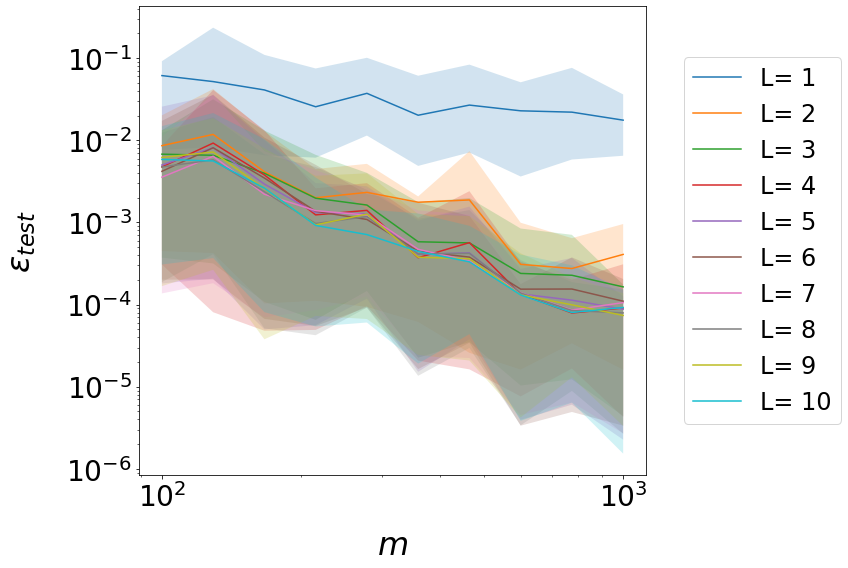

In [25]:
#Plot Error over training set sizes
plt.figure(figsize=(12, 8))  #Size
results_mean = np.mean(results, axis = 2)
results_lower = np.sort(results, axis = 2)[:,:,1] # 90% confidence intervals
results_upper = np.sort(results, axis = 2)[:,:,-2] # 90% confidence intervals

for i in range(len(Lay_x_Neu)):
    plt.loglog(Nsamples, results_mean[i,:], label=f'L= {i + 1}')
    plt.fill_between(Nsamples, results_lower[i,:], results_upper[i,:],  alpha=0.2)

plt.xlabel(r'$m$', fontsize=32, labelpad=18)
plt.ylabel(r'$\epsilon_{test}$', fontsize=32, labelpad=28)


# Increase font size of axis tick labels
plt.tick_params(axis='both', which='major', labelsize=28)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=28)  # Minor ticks

plt.legend(fontsize=28, loc='lower left')

plt.legend(
    fontsize=24,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place the legend to the right of the plot
    ncol=1  # Single column for legend entries
)

plt.tight_layout()  # Adjust the picture

plt.savefig("errorNN2D.pdf")


plt.show()